Data-driven prediction of $\alpha_{IIb}\beta_{3}$ integrin activation pathways using nonlinear manifold learning and deep generative modeling

Description: Generating points in the 2D physical space (Fig 7 in the paper).

Reference notebook: cg_300_integrated_training_integrin_dmap_decoder.ipynb

Approaches to use this notebook:
1. Several cells are commented to avoid re-calculating. You can use previously saved data to generate Fig 7.
(NOTE: Because of large data size, a separate repo (https://github.com/sivadasetty/integrin_data) contains the data used in this repo.)
2. Otherwise, uncomment the cells and rerun.


In [1]:
# Load required packages
import os
import sys
import math
import time
import pickle
import copy
import MDAnalysis as mda
import networkx as nx
import random
import acpype
import pandas as pd
from MDAnalysis.analysis import distances


import numpy as np
from scipy.linalg import eigh
from scipy.spatial.distance import pdist
from scipy.interpolate import interp1d
import matplotlib as mpl
from matplotlib import ticker
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
    
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch

from sklearn.preprocessing import MinMaxScaler

from jax import numpy as jnp, jit, vmap
from MDAnalysis.analysis import rms #diffusionmap, align, rms

import nglview as nv


no display found. Using non-interactive Agg backend


In [2]:
# Load required custom software

from importlib import reload 

import sys
sys.path.append('../../../')
from elss_software.molgen.molgen.models import WGANGP


import codes.dMap_JAX 
reload(codes.dMap_JAX )

from codes.dMap_JAX.dmap_JAX import dMap_jax, rmsd_jax
from codes.dMap_JAX.dmap_JAX import diff_plots


from molgen.models import WGANGP


#### global plot settings

In [3]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    
font = {'weight' : 'normal',
        'size'   : 25}

plt.rc('font', **font)

#### load saved integrin trajectories (training samples in 300 bead CG resolution)

In [4]:
# #### save eigen values

# with open(r"../../gan_saved_models/integrin_aa_cg_300_original_aligned_2450_pertraj.pkl", "rb") as input_file:
#     saved_traj = pickle.load(input_file)

# cat_trajs = saved_traj['cat_trajs']
# aligned_cat_trajs = saved_traj['aligned_cat_trajs']
# aligned_cat_excl_trajs = saved_traj['aligned_cat_excl_trajs']


#### load dMaps (4D conditional input to cWGAN)

In [5]:
# #### save eigen values

# with open(r"../../gan_saved_models/evecs_evals_integrin_aa_cg_300.pkl", "rb") as input_file:
#     dMaps_saved = pickle.load(input_file)

# lamb = dMaps_saved['lamb']
# psi = dMaps_saved['psi']

#### training data for decoder (no training done in this notebook)

In [6]:
# real_trj_list = [aligned_cat_trajs[0:2450].reshape(2450, -1),
#                  aligned_cat_trajs[2450:2450*2].reshape(2450, -1),
#                  aligned_cat_trajs[2450*2:2450*3].reshape(2450, -1), 
#                  aligned_cat_trajs[2450*3:2450*4].reshape(2450, -1)]

# real_trj_list = [torch.tensor(x).float() for x in real_trj_list]

# print(real_trj_list[0].shape)

# psi_list = [psi[0:2450, 1:5],
#             psi[2450:2450*2, 1:5],
#             psi[2450*2:2450*3, 1:5],
#             psi[2450*3:2450*4, 1:5]]

# psi_list = [torch.tensor(x) for x in psi_list]

# print(psi_list[0].shape)

#### Load trained cWGAN

In [7]:

# f_model_gan = WGANGP(feature_dim=real_trj_list[0].shape[1], condition_dim=psi_list[0].shape[1], 
#                      gen_hidden_dim=256, dis_hidden_dim=256, lambda_gp=10.0, n_critic=5, 
#                      latent_dim=128, lr=5e-5, opt='rmsprop')
             

In [8]:
# f_model_gan = f_model_gan.load_from_checkpoint('../../gan_saved_models/wgangp_b_100_e1000.ckpt')

#### Generate configurations using trained cWGAN by conditioning on 4D latent space to generate dense samples in 2D physical space

In [9]:
# #### real and fake -- extract fake
# with open(r"../../gan_saved_models/integrin_aa_cg_300_original_generated_2450_pertraj_b100_e1000.pkl", "rb") as input_file:
#    get_combine_orig_gen_traj = pickle.load(input_file)
   
# get_gen_traj = get_combine_orig_gen_traj['combine_orig_gen_traj'][:9800]

# get_gen_traj.shape

#### Location of the 4D points in latent space to generate dense samples in 2D physical space (pink markers of Fig. 7)

In [10]:
# psi1_psi2_space = np.concatenate(psi_list, axis=0)

# n = 10
# xy_min = [1*psi1_psi2_space[:,0].min(), 1*psi1_psi2_space[:,1].min(), 
#           psi1_psi2_space[:,2].min(), psi1_psi2_space[:,3].min()]
# xy_max = [1*psi1_psi2_space[:,0].max(), psi1_psi2_space[:,1].max(), 
#           1*psi1_psi2_space[:,2].max(), psi1_psi2_space[:,3].max()]

# #xy_min = [0.000043,-0.000098, 0.000095, 0.000195]
# #xy_max = [-0.000006, -0.000095, 0.000102, 0.000260]

# psi1_psi2_space_data_1 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(20000,4))

# xy_min = [0.00014,-0.000111,-0.000047,  0.000088]
# xy_max = [-0.000006, -0.000095,0.000102, 0.000260]


# psi1_psi2_space_data_2 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(10000,4))

# xy_min = [0.000164, -0.000111, -0.000047, 0.000088]
# xy_max = [0.000094, -0.000106, 0.000011, 0.000159]

# psi1_psi2_space_data_3 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(10000,4))

# xy_min=[0.000134,-0.000109,0.0001,0.0001]
# xy_max=[0.000074,-0.000109,0.00001,0.0003]

# psi1_psi2_space_data_4 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(10000,4))

# xy_min=[0.000134,-0.000109,0.000020,0.000246]
# xy_max=[0.00013,-0.000109,0.000087,0.000197]

# psi1_psi2_space_data_5 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(10000,4))

# xy_min=[0.00013,-0.000109,0.000097,0.000201]
# xy_max=[0.000115,-0.000109,0.000027,0.0003]

# psi1_psi2_space_data_6 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(10000,4))

# xy_min=[0.000134,-0.000109,0.000020,0.000246]
# xy_max=[0.000126,-0.000109,0.000086,0.000224]

# psi1_psi2_space_data_7 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(10000,4))

# xy_min=[0.000132,-0.000109,0.000059,0.000242]
# xy_max=[0.000125,-0.000109,0.00007,0.00025]

# psi1_psi2_space_data_8 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(10000,4))


# psi1_psi2_space_data = np.concatenate((psi1_psi2_space_data_1, psi1_psi2_space_data_2,
#                                        psi1_psi2_space_data_3, psi1_psi2_space_data_4,
#                                        psi1_psi2_space_data_5, psi1_psi2_space_data_6,
#                                        psi1_psi2_space_data_7, psi1_psi2_space_data_8))


In [11]:
# psi1_psi2_space.shape, psi1_psi2_space_data.shape

In [12]:
# ##### apply decoder over transition regions

# get_gan_training_points = f_model_gan.generate(torch.tensor(psi1_psi2_space).float()).reshape(-1,300,3)
# get_transition_points = f_model_gan.generate(torch.tensor(psi1_psi2_space_data).float()).reshape(-1,300,3)

# get_transition_points.shape, get_gan_training_points.shape

In [13]:

# gen_traj_transition_points = np.concatenate((get_transition_points, get_gan_training_points))

# gen_traj_transition_points_real = np.concatenate((get_transition_points, get_gen_traj))

# gen_traj_transition_points.shape, gen_traj_transition_points_real.shape

#### SAVE the generated configurations

In [14]:
#with open(r"integrin_aa_cg_300_generated_2450_pertraj_tranistion_10_b100_e1000.pkl", "wb") as f:
#    pickle.dump({'gen_traj_transition_points': np.array(gen_traj_transition_points)}, f)
#    

#### Calculate distances between chains and head-leg of all the generated points (pink markers in Fig 7)

#### first create a MD analysis universe

In [15]:
# ### create a universe for CG model [from example in MDAnalysis]

# n_residues = 300
# n_atoms = n_residues

# # create resindex list
# resindices = np.arange(n_residues)

# # all water molecules belong to 1 segment
# segindices = [0] * n_residues

# # create the Universe
# cg_1_universe = mda.Universe.empty(n_atoms,
#                                  n_residues=n_residues,
#                                  atom_resindex=resindices,
#                                  residue_segindex=segindices,
#                                  trajectory=True) # necessary for adding coordinates


# ### topology attributes
# from MDAnalysis.coordinates.memory import MemoryReader

# cg_1_universe.add_TopologyAttr('name', ['CG']*n_residues)
# cg_1_universe.add_TopologyAttr('type', ['CG']*n_residues)
# cg_1_universe.add_TopologyAttr('resid', list(range(1, n_residues+1)))
# cg_1_universe.add_TopologyAttr('segid', ['INT'])

# #### frame 0 positions

# #gen_traj_transition_points_real replace for real combo or for fake call gen_traj_transition_points
# cg_1_universe.atoms.positions = gen_traj_transition_points_real[0]

# cg_1_universe.load_new(np.array(gen_traj_transition_points_real), format=MemoryReader)


#### visualize if needed

In [16]:
# view = nv.show_mdanalysis(cg_1_universe)

# # clear representations
# #view.clear_representations()

# #view.add_representation('spacefill')
# view._remote_call("setSize", target="Widget", args=["1000px", "500px"])
# #?view.center_view()

# # specify color
# view.add_representation('spacefill', selection=np.arange(169), color='blue', radius=3.5, opacity=0.85)
# view.add_representation('spacefill', selection=np.arange(169,300), color='red', radius=3.5, opacity=0.85)
# view.add_representation('cartoon', color='black')


# view

#### real_gan combination: real implies training samples and gan imples all generated points

In [17]:
# real_cog_chains_cg_wgan = []
# real_cog_headtail_cg_wgan = []
# real_cog_tail_helices_cg_wgan = []
# real_cog_beta_prop_beta_td_cg_wgan = []
# real_time_cg_wgan = []

# for rep in cg_1_universe.trajectory:

    
#     #print(rep.select_atoms('index 0 to 168').center_of_geometry())
    
#     select_chain1 = cg_1_universe.select_atoms('index 0 to 168').center_of_geometry()
#     select_chain2 = cg_1_universe.select_atoms('index 169 to 299').center_of_geometry()
    
#     real_cog_chains_cg_wgan.append(np.linalg.norm(select_chain1-select_chain2))
    
#     select_head = cg_1_universe.select_atoms('index 0 to 154 or index 169 to 281').center_of_geometry()
#     select_tail = cg_1_universe.select_atoms('index 155 to 168 or index 282 to 299').center_of_geometry()
    
#     real_cog_headtail_cg_wgan.append(np.linalg.norm(select_head-select_tail))
    
#     select_tail1 = cg_1_universe.select_atoms('index 155 to 168').center_of_geometry()
#     select_tail2 = cg_1_universe.select_atoms('index 282 to 299').center_of_geometry()
    
#     real_cog_tail_helices_cg_wgan.append(np.linalg.norm(select_tail1-select_tail2))
    
#     select_beta_prop = cg_1_universe.select_atoms('index 0 to 64').center_of_geometry()
#     select_beta_td = cg_1_universe.select_atoms('index 259 to 281').center_of_geometry()
    
#     real_cog_beta_prop_beta_td_cg_wgan.append(np.linalg.norm(select_beta_prop-select_beta_td))
    
#     real_time_cg_wgan.append(cg_1_universe.trajectory.time)
    
# real_cog_chains_cg_wgan = np.array(real_cog_chains_cg_wgan)
# real_cog_headtail_cg_wgan = np.array(real_cog_headtail_cg_wgan)
# real_cog_tail_helices_cg_wgan = np.array(real_cog_tail_helices_cg_wgan)
# real_cog_beta_prop_beta_td_cg_wgan = np.array(real_cog_beta_prop_beta_td_cg_wgan)
# real_time_cg_wgan = np.array(real_time_cg_wgan)


#### Plot location of generated points in latent space and color by the physical space metrics

In [18]:
# %matplotlib inline
# ### color 
# colors = cog_tail_helices_cg_wgan/10
# #colors = cog_beta_prop_beta_td_cg_wgan/10
# #colors = cog_chains_cg_wgan/10
# #colors = cog_headtail_cg_wgan/10

# colorlabel=r'tail $\alpha_{helix}-\alpha_{helix}$ [nm]',
# #colorlabel=r'$\beta_{Propeller}-\beta_{TD}$ [nm]'
# #colorlabel=r'$\alpha_{unit}-\beta_{unit}$ [nm]'
# #colorlabel=r'$head-tail$ [nm]'

# ticks = list(np.arange(colors.min(), colors.max()))
# diff_plots.plot2Dmaps(psi_relevant_space, 3.982, plot_stride=1, select_max_vecs=3, 
#            skip_lead=False, colorMap=colors, cmap='coolwarm', colorbar=True, 
#            colorlabel='',
#            figSuffix='2d_relevant_space_taildistances_opt1')
#             #, ticks=[10,12,14,16], offset=1, cticklabels=[10,12,14,16])


#### find where tail helices are minimum and maximum


In [19]:
# psi_dist_df = pd.DataFrame({'psi_2': psi_relevant_space[:90000,0], 'psi_3': psi_relevant_space[:90000,1],
#                             'psi_4': psi_relevant_space[:90000,2], 'psi_5': psi_relevant_space[:90000,3],
#                              'dist1': cog_tail_helices_cg_wgan[:90000]/10,
#                              'dist2': cog_beta_prop_beta_td_cg_wgan[:90000]/10})


In [20]:
# psi_dist_df[(psi_dist_df['dist1'] <= psi_dist_df['dist1'].min()+0.5) &  (psi_dist_df['dist2'] <= psi_dist_df['dist2'].min()+0.5)]

# psi_dist_df[(psi_dist_df['dist1'] <= psi_dist_df['dist1'].min()+0.5) &  (psi_dist_df['dist2'] <= 6.5)]



In [21]:
# psi_dist_df[(psi_dist_df['dist1'] >= psi_dist_df['dist1'].max()-4) &  
#             (psi_dist_df['dist2'] <= psi_dist_df['dist2'].min()+2.5)]


#### save trajectory and distances 

In [22]:
# psi_dist_df = pd.DataFrame({'psi_2': psi_relevant_space[:,0], 'psi_3': psi_relevant_space[:,1],
#                             'psi_4': psi_relevant_space[:,2], 'psi_5': psi_relevant_space[:,3],
#                              'tailh_dist': cog_tail_helices_cg_wgan/10,
#                              'betap_dist': cog_beta_prop_beta_td_cg_wgan/10,
#                              'chain_dist': cog_chains_cg_wgan/10,
#                              'headtail_dist': cog_headtail_cg_wgan/10
#                            })

# psi_dist_df.to_pickle('./switchblade_deadbolt_gan_data_psi_distances.pkl')

In [23]:
# with open(r"switchblade_deadbolt_gan_data_traj.pkl", "wb") as f:
#     pickle.dump({'gen_traj_transition_points': np.array(gen_traj_transition_points)}, f)
   

In [24]:
# psi_dist_df = pd.DataFrame({'psi_2': psi_relevant_space[:,0], 'psi_3': psi_relevant_space[:,1],
#                             'psi_4': psi_relevant_space[:,2], 'psi_5': psi_relevant_space[:,3],
#                              'tailh_dist': real_cog_tail_helices_cg_wgan/10,
#                              'betap_dist': real_cog_beta_prop_beta_td_cg_wgan/10,
#                              'chain_dist': real_cog_chains_cg_wgan/10,
#                              'headtail_dist': real_cog_headtail_cg_wgan/10
#                            })

# psi_dist_df.to_pickle('./switchblade_deadbolt_gan_data_psi_distances_real.pkl')

In [25]:
# with open(r"switchblade_deadbolt_gan_data_traj_real.pkl", "wb") as f:
#     pickle.dump({'gen_traj_transition_points_real': np.array(gen_traj_transition_points_real)}, f)
   

#### Load previously calculated data [Fig 7]

In [26]:
# Read saved data
with open(r"Fig7_data/switchblade_deadbolt_gan_data_psi_distances.pkl", "rb") as input_file:
    psi_traj_gan = pickle.load(input_file)
    
psi_relevant_space = np.vstack((psi_traj_gan['psi_2'], psi_traj_gan['psi_3'], psi_traj_gan['psi_4'], psi_traj_gan['psi_5'] )).T
cog_tail_helices_cg_wgan = psi_traj_gan['tailh_dist']*10
cog_beta_prop_beta_td_cg_wgan = psi_traj_gan['betap_dist']*10
cog_chains_cg_wgan = psi_traj_gan['chain_dist']*10
cog_headtail_cg_wgan = psi_traj_gan['headtail_dist']*10

with open(r"Fig7_data/switchblade_deadbolt_gan_data_traj.pkl", "rb") as input_file:
    gen_traj_transition_points = pickle.load(input_file)['gen_traj_transition_points']
    
with open(r"Fig7_data/switchblade_deadbolt_gan_data_psi_distances_real.pkl", "rb") as input_file:
    psi_traj = pickle.load(input_file)

real_cog_tail_helices_cg_wgan = psi_traj['tailh_dist']*10
real_cog_beta_prop_beta_td_cg_wgan = psi_traj['betap_dist']*10
real_cog_chains_cg_wgan = psi_traj['chain_dist']*10
real_cog_headtail_cg_wgan = psi_traj['headtail_dist']*10
    
with open(r"Fig7_data/switchblade_deadbolt_gan_data_traj_real.pkl", "rb") as input_file:
    gen_traj_transition_points_real = pickle.load(input_file)['gen_traj_transition_points_real']
    


#### Generate Bezier curves along switchblade and deadbolt pathways -- Fig 7 (blue markers)

In [27]:
from scipy.special import comb

def generate_points_between(p0, p1, p2, p3, num_points):
    points = []
    for t in np.linspace(0, 1, num_points):
        x = (comb(3, 0) * (1 - t)**3 * p0[0]) + (comb(3, 1) * (1 - t)**2 * t * p1[0]) + (comb(3, 2) * (1 - t) * t**2 * p2[0]) + (comb(3, 3) * t**3 * p3[0])
        y = (comb(3, 0) * (1 - t)**3 * p0[1]) + (comb(3, 1) * (1 - t)**2 * t * p1[1]) + (comb(3, 2) * (1 - t) * t**2 * p2[1]) + (comb(3, 3) * t**3 * p3[1])
        points.append((x, y))
    
    return points

# switch
p0 = (cog_tail_helices_cg_wgan[3786]/10, cog_beta_prop_beta_td_cg_wgan[3786]/10)
p1 = (cog_tail_helices_cg_wgan[79391]/10, cog_beta_prop_beta_td_cg_wgan[3786]/10)
p2 = (cog_tail_helices_cg_wgan[69504]/10, cog_beta_prop_beta_td_cg_wgan[69504]/10)
p3 = (cog_tail_helices_cg_wgan[2076]/10, cog_beta_prop_beta_td_cg_wgan[2076]/10)
num_points = 10
switch_curve_points = generate_points_between(p0, p1, p2, p3, num_points)

# beta
p0 = (cog_tail_helices_cg_wgan[30094]/10, cog_beta_prop_beta_td_cg_wgan[30094]/10)
p1 = (cog_tail_helices_cg_wgan[13892]/10, cog_beta_prop_beta_td_cg_wgan[13892]/10)
p2 = (cog_tail_helices_cg_wgan[19254]/10, cog_beta_prop_beta_td_cg_wgan[19254]/10)
p3 = (cog_tail_helices_cg_wgan[15108]/10, cog_beta_prop_beta_td_cg_wgan[15108]/10)
num_points = 10
beta_curve_points = generate_points_between(p0, p1, p2, p3, num_points)

# mid
p0 = (cog_tail_helices_cg_wgan[4417]/10, cog_beta_prop_beta_td_cg_wgan[4417]/10)
p1 = (cog_tail_helices_cg_wgan[10372]/10, cog_beta_prop_beta_td_cg_wgan[10372]/10)
p2 = (cog_tail_helices_cg_wgan[20562]/10, cog_beta_prop_beta_td_cg_wgan[20562]/10)
p3 = (cog_tail_helices_cg_wgan[23980]/10, cog_beta_prop_beta_td_cg_wgan[23980]/10)
num_points = 6
mid_curve_points = generate_points_between(p0, p1, p2, p3, num_points)


def find_closest_index(tuple_data, target_point):
    closest_index = None
    closest_distance = float('inf')
    
    for i, element in enumerate(tuple_data):
        distance = math.dist(element, target_point)
        if distance < closest_distance:
            closest_distance = distance
            closest_index = i
    
    return closest_index


tuple_data = tuple(zip(cog_tail_helices_cg_wgan/10, cog_beta_prop_beta_td_cg_wgan/10))


switch_indices = [find_closest_index(tuple_data, switch_curve_points[i]) for i in range(len(switch_curve_points))]
beta_indices = [find_closest_index(tuple_data, beta_curve_points[i]) for i in range(len(beta_curve_points))]
mid_indices = [find_closest_index(tuple_data, mid_curve_points[i]) for i in range(len(mid_curve_points))]

all_indices = np.concatenate((switch_indices,beta_indices,mid_indices))
all_indices


array([ 3786, 16387, 87508, 86575, 87182, 72565, 46266, 17380,  2153,
        2076, 30094,  9605,  8258, 34757, 10350,    69, 92595,  6135,
       17841, 15108,  4417, 24602, 29023, 17621, 97458, 23980])

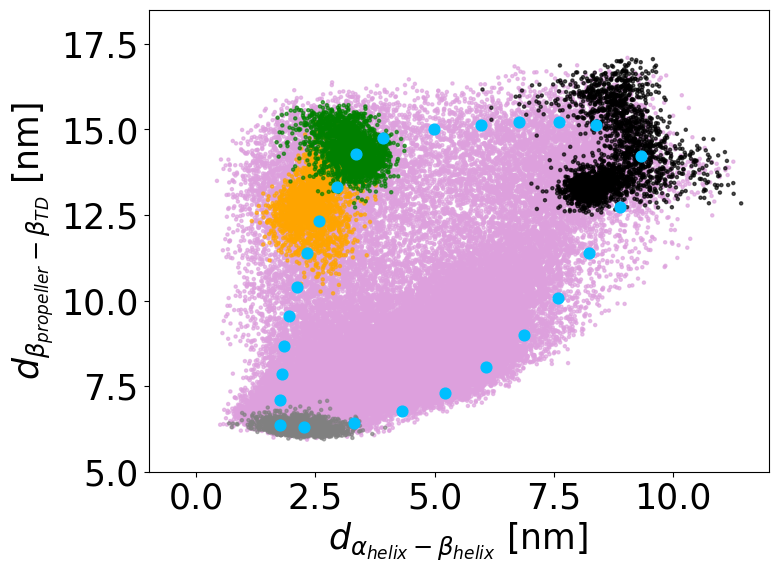

In [36]:
#%matplotlib notebook
%matplotlib inline

import mplcursors

# plot
fig = plt.figure(figsize=(8,6))


#colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3, np.ones(2450)*4, np.ones(psi1_psi2_space_data.shape[0])*5]
colors = [np.ones(90000)*1, np.ones(2450)*2, np.ones(2450)*3, np.ones(2450)*4, np.ones(2450)*5]

colors = np.concatenate(colors, axis=0)
lcmap = (mpl.colors.ListedColormap(['plum', 'gray', 'orange', 'green', 'black']) #'red', 'black'
        .with_extremes(over='0.25', under='0.75'))

ax1 = fig.add_subplot(111)

   
i=0
ax1.scatter(real_cog_tail_helices_cg_wgan/10,
            real_cog_beta_prop_beta_td_cg_wgan/10, c=colors, cmap=lcmap, s=5, alpha=0.65)

ax1.set_ylabel(r"$d_{\beta_{propeller}-\beta_{TD}}$ [nm]")
ax1.set_xlabel(r'$d_{\alpha_{helix}-\beta_{helix}}$ [nm]')

ax1.set_xlim(-1, 12)
ax1.set_ylim(5, 18.5)

for fr in switch_indices:
    
    ax1.scatter(cog_tail_helices_cg_wgan[fr]/10, 
                cog_beta_prop_beta_td_cg_wgan[fr]/10, marker='o', s=60, color='deepskyblue', alpha=1)
    
    x = cog_tail_helices_cg_wgan[fr]/10
    y = cog_beta_prop_beta_td_cg_wgan[fr]/10
    label=fr
    #ax1.text(x, y, '%s' % (label), size=10, zorder=1, color='red')
    
for fr in beta_indices:
    
    ax1.scatter(cog_tail_helices_cg_wgan[fr]/10, 
                cog_beta_prop_beta_td_cg_wgan[fr]/10, marker='o', s=60, color='deepskyblue', alpha=1)
    
    x = cog_tail_helices_cg_wgan[fr]/10
    y = cog_beta_prop_beta_td_cg_wgan[fr]/10
    label=fr
    #ax1.text(x, y, '%s' % (label), size=10, zorder=1, color='red')
    
for fr in mid_indices:
    
    ax1.scatter(cog_tail_helices_cg_wgan[fr]/10, 
                cog_beta_prop_beta_td_cg_wgan[fr]/10, marker='o', s=60, color='deepskyblue', alpha=1)
    
    x = cog_tail_helices_cg_wgan[fr]/10
    y = cog_beta_prop_beta_td_cg_wgan[fr]/10
    label=fr
    #ax1.text(x, y, '%s' % (label), size=10, zorder=1, color='red')
       

mplcursors.cursor(ax1).connect("add", lambda sel: sel.annotation.set_text(sel.index))

# Set the number of ticks on the x-axis directly
num_ticks = 6
locator = ticker.MaxNLocator(num_ticks)
plt.gca().xaxis.set_major_locator(locator)

plt.show()
        
#fig.savefig("distance_cg_300_deadbolt_domains_2d.png",dpi=150)

#### Generate snapshots using closest available generated configuration to blue maker 

In [37]:
x = [418, 3786, 18327, 51791, 79391, 43725, 69504, 29833, 15738,
     2076, 23980, 20461, 28012, 10455, 15168, 6008, 96288, 96987, 95561,
     10216, 15325, 94516, 15368, 19254, 9998, 23878, 19244, 13892, 28696, 4063]

x = all_indices

selected_gen_traj_transition_points = gen_traj_transition_points_real[np.array(x)]
selected_gen_traj_transition_points.shape

(26, 300, 3)

#### Create a universe for CG model using MD analysis for visualization

In [38]:
n_residues = 300
n_atoms = n_residues

# create resindex list
resindices = np.arange(n_residues)

# all water molecules belong to 1 segment
segindices = [0] * n_residues

# create the Universe
cg_1_universe = mda.Universe.empty(n_atoms,
                                 n_residues=n_residues,
                                 atom_resindex=resindices,
                                 residue_segindex=segindices,
                                 trajectory=True) # necessary for adding coordinates



### topology attributes
from MDAnalysis.coordinates.memory import MemoryReader

cg_1_universe.add_TopologyAttr('name', ['CG']*n_residues)
cg_1_universe.add_TopologyAttr('type', ['CG']*n_residues)
cg_1_universe.add_TopologyAttr('resid', list(range(1, n_residues+1)))
cg_1_universe.add_TopologyAttr('segid', ['INT'])

#### frame 0 positions

cg_1_universe.atoms.positions = selected_gen_traj_transition_points[0]

cg_1_universe.load_new(np.array(selected_gen_traj_transition_points), format=MemoryReader)


<Universe with 300 atoms>

In [39]:
view = nv.show_mdanalysis(cg_1_universe)

# clear representations
view.clear_representations()

#view.add_representation('spacefill')
view._remote_call("setSize", target="Widget", args=["800px", "600px"])
#?view.center_view()

# specify color
view.add_representation('spacefill', selection=np.arange(169), color='blue', radius=3.5, opacity=0.85)
view.add_representation('spacefill', selection=np.arange(169,300), color='red', radius=3.5, opacity=0.85)
#view.add_representation('cartoon', color='black')


view

NGLWidget(max_frame=25)